<a href="https://colab.research.google.com/github/DiegoCorona/TensorFlow2-for-Deep-Learning/blob/main/Week4_Customising_your_models_with_TensorFlow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [ ]:
# Build the model

## Part 1
class MyModel(Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation = 'relu')
    self.dense_2 = Dense(10)
    self.dropout = Dropout(0.4)

  def call(self, inputs, training = False):
    x = self.dense_1(inputs)
    if training:
      x = self.dropout(x)
    return self.dense_2(x)

## Part 2
class MyModel(Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation = 'relu')
    self.dense_2 = Dense(10)
    self.dense_3 = Dense(5)
    self.softmax = Softmax()

  def call(self, inputs, training = False):
    x = self.dense_1(inputs)
    y1 = self.dense_2(inputs)
    y2 = self.dense_3(y1)
    concat = concatenate([x, y2]) ### Topologia no lineal
    return self.softmax(concat)

In [ ]:
# Print the model summary
model = MyModel()
model(tf.random.uniform((1, 10)))
model.summary()

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  704       
_________________________________________________________________
dense_8 (Dense)              multiple                  110       
_________________________________________________________________
dense_9 (Dense)              multiple                  55        
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [ ]:
# Create a custom layer
class MyLayer(Layer):

  def __init__(self, units , input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape=(units, ),
                             initializer = 'zeros')
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b


dense_layer = MyLayer(3, 5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[-0.01124877  0.13560696  0.0162329 ]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.0392927 ,  0.04329731,  0.12007912],
       [-0.04622946,  0.08554196, -0.00473463],
       [-0.00126211,  0.01312274, -0.04982891],
       [ 0.05685247, -0.05220957, -0.01613145],
       [ 0.01868302,  0.04585452, -0.03315123]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [ ]:
# Specify trainable weights
class MyLayer(Layer):

  def __init__(self, units , input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer = 'random_normal', 
                             trainable = False)
    self.b = self.add_weight(shape=(units, ),
                             initializer = 'zeros',
                             trainable = False)
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)

In [ ]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [ ]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):

  def __init__(self, units , input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape=(units, ),
                             initializer = 'zeros')
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                      trainable = False)
    self.number_call = tf.Variable(initial_value=0,
                                   trainable = False)
    
  def call(self, inputs):
    activations = tf.matmul(inputs, self.w) + self.b
    self.sum_activation.assign_add(tf.reduce_sum(activations, axis = 0))
    self.number_call.assign_add(inputs.shape[0])
    return activations, self.sum_activation/tf.cast(self.number_call, tf.float32)


dense_layer = MyLayerMean(3, 5)

In [ ]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[ 0.01963058  0.0974668  -0.07171822]
[ 0.01963058  0.0974668  -0.07171822]


In [ ]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)

#### Implement the custom layers into a model

In [ ]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)

In [ ]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.0590732  0.02881132 0.01820432 0.03390437 0.01189851 0.00782703
  0.00338054 0.02433166 0.01262501 0.0096845  0.01580717 0.02285367
  0.01646875 0.00672093 0.01852052 0.01775789 0.01714168 0.01119611
  0.01039013 0.01647911 0.02092763 0.00683467 0.05206288 0.05000358
  0.01092965 0.0167764  0.01672743 0.033005   0.03117854 0.0224652
  0.05188052 0.04419989 0.02763607 0.01584372 0.00938167 0.02505554
  0.00679129 0.01707663 0.00533395 0.02689054 0.02253005 0.02015457
  0.04356915 0.01818806 0.02776226 0.01371865]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

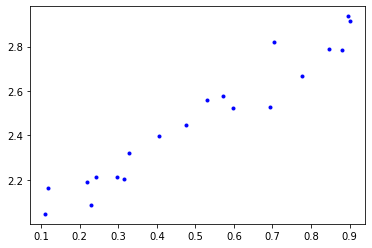

In [3]:
# Create data from a noise contaminated linear model
def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [4]:
from tensorflow.keras.layers import Layer

In [7]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(shape = (1,),
                              initializer = 'random_normal')
    self.b = self.add_weight(shape = (1,),
                              initializer = 'zeros')
  
  def call(self, inputs):
    return self.m*inputs + self.b 

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.00151049 0.00037648 0.00280526 0.00094542 0.00129132 0.00223907
 0.00103986 0.00286602 0.00035408 0.00285472 0.00100501 0.0022093
 0.00073251 0.00182242 0.00247313 0.00069978 0.0016869  0.00269784
 0.00077235 0.00189867], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.0031826], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [8]:
# Define the mean squared error loss function
def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.165414


#### Train and plot the model

In [11]:
# Implement a gradient descent training loop for the linear regression model
learning_rate = 0.5
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)

  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[1])

  print("Step: %d, Loss: %f" % (i, loss.numpy()))

Step: 0, Loss: 6.165414
Step: 1, Loss: 0.460486
Step: 2, Loss: 0.038445
Step: 3, Loss: 0.007221
Step: 4, Loss: 0.004909
Step: 5, Loss: 0.004736
Step: 6, Loss: 0.004721
Step: 7, Loss: 0.004718
Step: 8, Loss: 0.004717
Step: 9, Loss: 0.004715
Step: 10, Loss: 0.004714
Step: 11, Loss: 0.004713
Step: 12, Loss: 0.004712
Step: 13, Loss: 0.004711
Step: 14, Loss: 0.004710
Step: 15, Loss: 0.004710
Step: 16, Loss: 0.004709
Step: 17, Loss: 0.004708
Step: 18, Loss: 0.004708
Step: 19, Loss: 0.004707
Step: 20, Loss: 0.004707
Step: 21, Loss: 0.004707
Step: 22, Loss: 0.004706
Step: 23, Loss: 0.004706
Step: 24, Loss: 0.004706


m:1,  trained m:[1.0271072]
b:2,  trained b:[1.9481429]


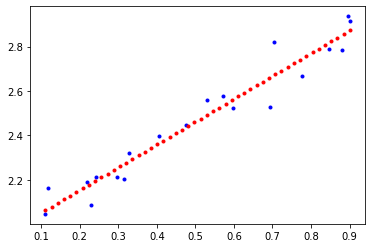

In [12]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [22]:
# Define the custom layers and model
class MyLayer(Layer):

  def __init__(self, units):
    super(MyLayer, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer = 'random_normal',
                             name = 'kernel')
    self.b = self.add_weight(shape=(self.units, ),
                             initializer = 'zeros',
                             name = 'bias')
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

#########################################################################
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)

#########################################################################
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1,)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        
        return self.softmax(x)

In [23]:
model = MyModel(64, 64,64)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.00847305 0.0104279  0.04621356 0.01273845 0.00882502 0.01100962
  0.02753854 0.02613953 0.00743106 0.00274039 0.01812492 0.02089678
  0.01128594 0.01963484 0.00661109 0.03368312 0.00931806 0.0247556
  0.01253277 0.02193937 0.00715741 0.00945292 0.01392419 0.0270541
  0.01191115 0.01630029 0.01746098 0.02132128 0.00583977 0.01244462
  0.01232213 0.00570599 0.00360004 0.02218841 0.01572526 0.00838939
  0.0034625  0.00484762 0.02196828 0.01166667 0.0019599  0.08063234
  0.00706348 0.01735109 0.01253621 0.0045287  0.0200763  0.0131636
  0.00315028 0.00791877 0.01035973 0.01342444 0.00828574 0.01180635
  0.00860502 0.06709122 0.02158589 0.01710251 0.03378021 0.00741757
  0.00916971 0.01202142 0.00546248 0.01244438]], shape=(1, 64), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_7 (MyLayer)         multiple                  640064    
_______________

#### Load the reuters dataset and define the class_names 

In [24]:
# Load the dataset
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [25]:
# Print the class of the first sample
print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [26]:
# Load the Reuters word index
word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [28]:
# Print the first data example sentence
import pprint
pprint.pprint(text_news)

('? ? ? said as a result of its december acquisition of space co it expects '
 'earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in '
 '1986 the company said pretax net should rise to nine to 10 mln dlrs from six '
 'mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 '
 '5 mln dlrs it said cash flow per share this year should be 2 50 to three '
 'dlrs reuter 3')


#### Preprocess the data

In [29]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [37]:
# Define the categorical cross entropy loss and Adam optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [38]:
# Define a function to compute the forward and backward pass
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [41]:
# Implement the training loop
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

### Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

### Loop
for epoch in range(num_epochs):
  epoch_loss_average = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  ## Training loop
  for x, y in train_dataset:
    ## Optimize the model
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    ## Compute current loss
    epoch_loss_average(loss_value)
    ## Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

  ## End epoch 
  train_loss_results.append(epoch_loss_average.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}, Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_average.result(),
                                                              epoch_accuracy.result()))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000, Loss: 1.863, Accuracy: 64.986%
Epoch 001, Loss: 1.824, Accuracy: 67.468%
Epoch 002, Loss: 1.797, Accuracy: 67.802%
Epoch 003, Loss: 1.777, Accuracy: 68.882%
Epoch 004, Loss: 1.766, Accuracy: 68.982%
Epoch 005, Loss: 1.745, Accuracy: 69.906%
Epoch 006, Loss: 1.726, Accuracy: 69.884%
Epoch 007, Loss: 1.726, Accuracy: 70.396%
Epoch 008, Loss: 1.717, Accuracy: 70.730%
Epoch 009, Loss: 1.699, Accuracy: 70.697%
Duration :102.586


#### Evaluate the model

In [42]:
# Create a Dataset object for the test set
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [43]:
# Collect average loss and accuracy
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [44]:
# Loop over the test set and print scores
from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.835
Test accuracy: 68.166%


#### Plot the learning curves

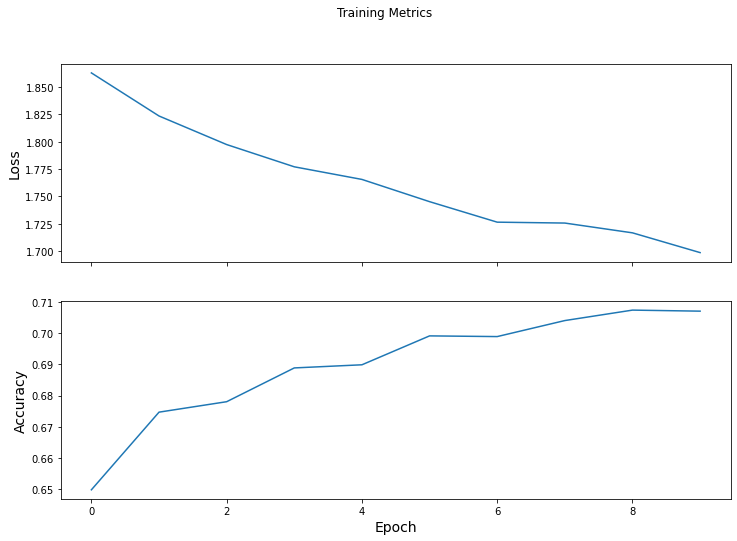

In [45]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [46]:
# Get the model prediction for an example input
predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [48]:
# Initialize a new model
model = MyModel(64,64,64)

#### Redefine the grad function using the @tf.function decorator

In [49]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [50]:
# Re-run the training loop
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

### Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

### Loop
for epoch in range(num_epochs):
  epoch_loss_average = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  ## Training loop
  for x, y in train_dataset:
    ## Optimize the model
    loss_value, grads = grad(model, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    ## Compute current loss
    epoch_loss_average(loss_value)
    ## Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

  ## End epoch 
  train_loss_results.append(epoch_loss_average.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}, Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                              epoch_loss_average.result(),
                                                              epoch_accuracy.result()))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000, Loss: 2.498, Accuracy: 55.288%
Epoch 001, Loss: 1.968, Accuracy: 63.872%
Epoch 002, Loss: 1.870, Accuracy: 66.900%
Epoch 003, Loss: 1.812, Accuracy: 68.214%
Epoch 004, Loss: 1.777, Accuracy: 68.726%
Epoch 005, Loss: 1.764, Accuracy: 69.272%
Epoch 006, Loss: 1.738, Accuracy: 69.483%
Epoch 007, Loss: 1.721, Accuracy: 69.439%
Epoch 008, Loss: 1.714, Accuracy: 69.962%
Epoch 009, Loss: 1.713, Accuracy: 69.784%
Duration :98.851


#### Print the autograph code

In [51]:
# Use tf.autograph.to_code to see the generated code
print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

